# Poisoning Attacks against Machine Learning models

In this tutorial we will experiment with **adversarial poisoning attacks** against a Support Vector Machine (SVM) with Radial Basis Function (RBF) kernel.

Poisoning attacks are performed at *training time* by injecting *carefully-crafted samples* that alter the classifier decision function so that its behavior at *testing time* is modified.

As in the previous tutorials, we will first create and train the classifier, evaluating its performance in the standard scenario, *i.e.*, not under attack, by using the standard accuracy metric.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/unica-mlsec/mlsec/blob/HEAD/labs/06_poisoning_attacks.ipynb)

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

# make sure you have the last version of secml
%pip install secml --upgrade

try:
    import secml
    import foolbox
except ImportError:
    %pip install secml
    %pip install foolbox

In [2]:
random_state = 999

n_features = 2  # number of features
n_samples = 1000  # number of samples
centers = [[-1, -1], [+1, +1]]  # centers of the clusters
cluster_std = 0.9  # standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs

dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 100  # number of training set samples
n_val = 100  # number of validation set samples
n_ts = 100  # number of test set samples

# split in training, validation and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr + n_val, test_size=n_ts, random_state=random_state)
tr_val, ts = splitter.split(dataset)
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_val, random_state=random_state)
tr, val = splitter.split(dataset)

# normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
val.X = nmz.transform(val.X)
ts.X = nmz.transform(ts.X)

# metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy

metric = CMetricAccuracy()

# creation of the multiclass classifier with RBF kernel
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernels import CKernelRBF

clean_clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)

# we can now fit the classifier
clean_clf.fit(tr.X, tr.Y)
print("Training of classifier complete!")

# compute predictions on a test set
y_pred = clean_clf.predict(ts.X)

acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
print(acc)

Training of classifier complete!
0.93


## Generation of Poisoning Samples

We are going to generate our attack against the SVM classifier using the **gradient-based** algorithm for generating poisoning attacks proposed in the following papers:
 
  > [[biggio12-icml]](https://arxiv.org/abs/1206.6389)
  > Biggio, B., Nelson, B. and Laskov, P., 2012. Poisoning attacks against 
  > support vector machines. In ICML 2012 (Test of Time Award).

  > [[biggio15-icml]](https://arxiv.org/abs/1804.07933)
  > Xiao, H., Biggio, B., Brown, G., Fumera, G., Eckert, C. and Roli, F., 2015. 
  > Is feature selection secure against training data poisoning?. In ICML 2015.

  > [[demontis19-usenix]](
  > https://www.usenix.org/conference/usenixsecurity19/presentation/demontis)
  > Demontis, A., Melis, M., Pintor, M., Jagielski, M., Biggio, B., Oprea, A., 
  > Nita-Rotaru, C. and Roli, F., 2019. Why Do Adversarial Attacks Transfer? 
  > Explaining Transferability of Evasion and Poisoning Attacks. In 28th Usenix 
  > Security Symposium, Santa Clara, California, USA.

To compute a poisoning point, we have to solve a bi-level optimization problem, namely:

$$
\begin{array}{cc}
\max _{\mathbf{x}_c} & \mathcal{A}\left(\mathcal{D}_{\text {val }}, \mathbf{w}^{\star}\right)=\sum_{j=1}^m \ell\left(y_j, \mathbf{x}_j, \mathbf{w}^{\star}\right) \\
\text { s.t. } & \mathbf{w}^{\star} \in \underset{\mathbf{w}}{\arg \min } \quad \mathcal{L}\left(\mathcal{D}_{\text {tr }} \cup\left(\mathbf{x}_c, y\right), \mathbf{w}\right)
\end{array}
$$

Where $\mathbf{x_c}$ is the poisoning point, $\mathcal{A}$ is the attacker objective function, $\mathcal{L}$ is the classifier training function.
Moreover, $D_{tr}$ is the training dataset and $D_{val}$ is the validation dataset.
The former problem, along with the poisoning point $\mathbf{x}_c$ is used to train the classifier on the poisoned data, while the latter is used to evaluate the performance on the untainted data.

The former equation depends on the classifier weights, which in turns, depends on the poisoning point.

This attack is implemented in SecML by different subclasses of the `CAttackPoisoning`.
For the purpose of attacking a SVM classifier we use the `CAttackPoisoningSVM` class.

As done for the evasion attacks, let's specify the parameters first. We set the bounds of the attack space to the known feature space given by validation dataset.
Lastly, we chose the solver parameters for this specific optimization problem.

Let's start visualizing the objective function considering a single poisoning point.

In [3]:
lb, ub = val.X.min(), val.X.max()  # bounds of the attack space

# the parameters should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 500,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningSVM

attack = CAttackPoisoningSVM(classifier=clean_clf,
                             training_data=tr,
                             val=val,
                             lb=lb, ub=ub,
                             solver_params=solver_params,
                             random_seed=random_state
                            )

# chose and set the initial poisoning sample features and label
xc = tr[0, :].X
yc = tr[0, :].Y
attack.x0 = xc
attack.xc = xc
attack.yc = yc

print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



Initial poisoning sample features: CArray([0.532825 0.556228])
Initial poisoning sample label: 1


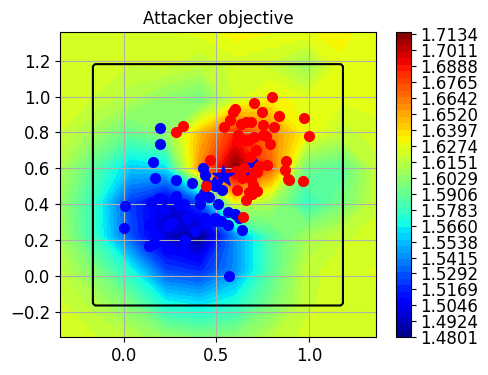

In [10]:
%matplotlib inline
from secml.figure import CFigure

fig = CFigure(4, 5)
grid_limits = [(lb - 0.1, ub + 0.1),
               (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0, :], markers='*', markersize=16)

fig.sp.title('Attacker objective')
fig.sp.plot_fun(
    func=attack.objective_function,
    grid_limits=grid_limits, plot_levels=False,
    n_grid_points=10, colorbar=True)

# plot the box constraint
from secml.optim.constraints import CConstraintBox

box = CConstraintBox(lb=lb, ub=ub)
fig.sp.plot_constraint(box, grid_limits=grid_limits,
                       n_grid_points=10)

fig.tight_layout()
fig.show()

Now, we set the desired number of poisoning points to generate, 20 in this example.

In [5]:
n_samples = 20
n_poisoning_points = n_samples  # number of poisoning points to generate
attack.n_points = n_poisoning_points

# run the poisoning attack
# this computes performances on the testing set 
# already (on a poisoned copy of the classifier)
pois_y_pred, pois_scores, pois_ds, f_opt = attack.run(ts.X, ts.Y)

# # optionally this can be done outside the attack
# poisoning_dataset = tr.append(pois_ds)
# poisoned_clf = clean_clf.deepcopy()
# poisoned_clf.fit(poisoning_dataset.X, poisoning_dataset.Y)
# pois_y_pred = poisoned_clf.predict(ts.X)

# evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

Original accuracy on test set: 93.00%
Accuracy after attack on test set: 86.00%


We can see that the classifiers has been successfully attacked.
To increase the attack power, more poisoning points can be crafted, at the expense of a much slower optimization process.

Let's now visualize the attack on a 2D plane.
We need to train a copy of the original classifier on the join between the training set and the poisoning points.

In [6]:
# train the poisoned classifier
poisoned_clf = clean_clf.deepcopy()
pois_tr = tr.append(pois_ds)  # join the training set with the poisoning points
poisoned_clf.fit(pois_tr.X, pois_tr.Y);

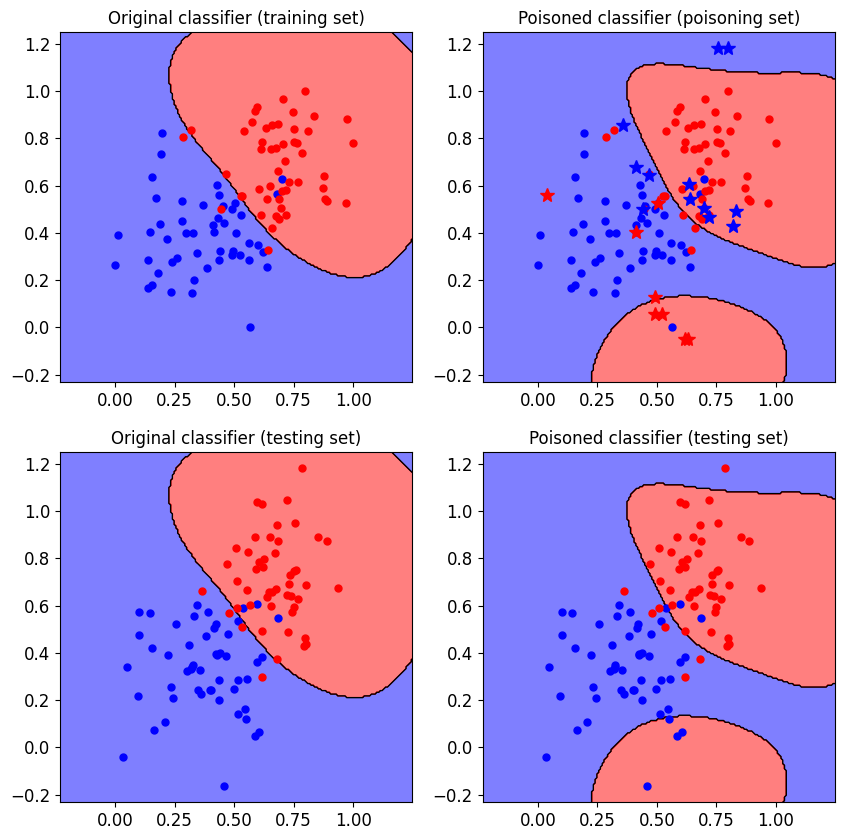

In [7]:
%matplotlib inline
# define common bounds for the subplots
min_limit = min(pois_tr.X.min(), ts.X.min())
max_limit = max(pois_tr.X.max(), ts.X.max())
grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

fig = CFigure(10, 10)

# let's plot:
#   1. the clean training data and the clean classifier decision regions
#   2. the poisoning training data and the poisoned classifier decision regions
#   3. the clean testing data and the clean classifier decision regions
#   4. the clean testing data and the poisoned classifier decision regions

fig.subplot(2, 2, 1)
fig.sp.title("Original classifier (training set)")
fig.sp.plot_decision_regions(clean_clf, n_grid_points=200, 
                             grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.grid(False)

fig.subplot(2, 2, 2)
fig.sp.title("Poisoned classifier (poisoning set)")
fig.sp.plot_decision_regions(poisoned_clf, n_grid_points=200, 
                             grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.plot_ds(pois_ds, markersize=10, markers='*')

fig.sp.grid(False)

fig.subplot(2, 2, 3)
fig.sp.title("Original classifier (testing set)")
fig.sp.plot_decision_regions(clean_clf, n_grid_points=200, 
                             grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.grid(False)

fig.subplot(2, 2, 4)
fig.sp.title("Poisoned classifier (testing set)")
fig.sp.plot_decision_regions(poisoned_clf, n_grid_points=200, 
                             grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.grid(False)

fig.show()

We can see how the SVM classifier decision functions *changes* after injecting the adversarial poisoning points (blue and red stars).
 
For more details about poisoning adversarial attacks, refer to:

  > [[biggio18-pr]](https://arxiv.org/abs/1712.03141)
  > Biggio, B. and Roli, F., 2018. Wild patterns: Ten years after the rise of 
  > adversarial machine learning. In Pattern Recognition.

# Performance of classifier for more poisoning samples

Instead of hard-coding the number of points, we can compute poisoning for different fractions of points, as we did for evasion attacks.
After each poisoning experiment, we train a classifier with both clean and poisoned samples and we compute the accuracy.

In [8]:
from secml.array import CArray

n_poisoning_samples = CArray([1, 10, 20, 75, 100])

poisoned_clfs = []
test_accuracies = []

# write a for loop that tests the effect of increasing poisoning samples
# keep track of the accuracies

for i, p in enumerate(n_poisoning_samples):
    print(f"Computing poisoning for {p} poisoning points.")
    attack = CAttackPoisoningSVM(classifier=clean_clf, training_data=tr,
                                 val=val, lb=lb, ub=ub, 
                                 solver_params=solver_params, 
                                 random_seed=random_state)
    attack.n_points = p
    _, _, poisoning_ds, _ = attack.run(ts.X, ts.Y)
    poisoned_clf = clean_clf.deepcopy()
    pois_tr = tr.append(poisoning_ds)
    poisoned_clf.fit(pois_tr.X, pois_tr.Y)
    poisoned_clfs.append(poisoned_clf)

    preds = poisoned_clf.predict(ts.X)
    acc = metric.performance_score(y_true=ts.Y, y_pred=preds)
    test_accuracies.append(acc)
    print("accuracy: ", acc)


Computing poisoning for 1 poisoning points.
accuracy:  0.92
Computing poisoning for 10 poisoning points.
accuracy:  0.91
Computing poisoning for 20 poisoning points.
accuracy:  0.87
Computing poisoning for 75 poisoning points.
accuracy:  0.43
Computing poisoning for 100 poisoning points.
accuracy:  0.08


[0.92, 0.91, 0.87, 0.43, 0.08]


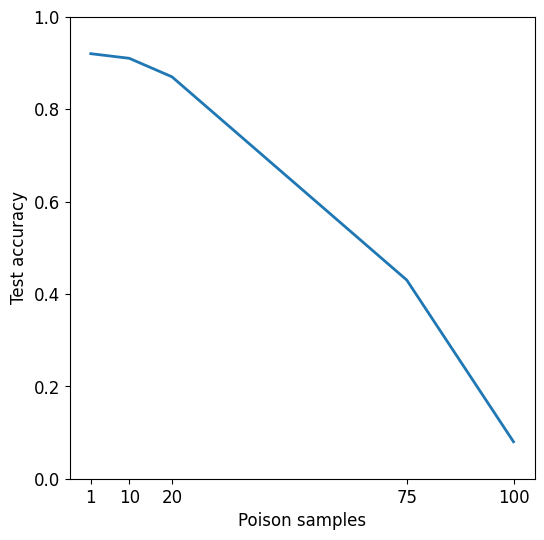

In [9]:
%matplotlib inline
print(test_accuracies)
fig = CFigure()
fig.sp.plot(n_poisoning_samples, test_accuracies)
fig.sp.xlabel('Poison samples')
fig.sp.xticks(n_poisoning_samples)
fig.sp.ylabel('Test accuracy')
fig.sp.ylim([0,1])
fig.show()

# Evaluating robustness of poisoned models to evasion attacks

In [13]:
from secml.adv.seceval import CSecEval
from secml.adv.attacks import CFoolboxPGDL2

steps = 100
abs_stepsize = 0.05
epsilons = CArray.linspace(0, 0.2, 5)

# NOTE this is considered cheating!!!
# we have to do it for bypassing foolbox's check on lb and ub
ts.X = nmz.fit_transform(ts.X)

sec_evals = []
for (poisoned_classifier, number_poisoning_points) in zip(
                        poisoned_clfs, n_poisoning_samples):
    print(f"Security evaluation of classifier with {number_poisoning_points}")
    evasion_attack = CFoolboxPGDL2(classifier=poisoned_classifier, steps=steps, 
                                   abs_stepsize=abs_stepsize, random_start=False)
    sec_eval = CSecEval(attack=evasion_attack, 
                        param_values=epsilons, param_name='epsilon')
    sec_eval.run_sec_eval(ts)
    sec_evals.append(sec_eval.sec_exval_data)




Security evaluation of classifier with 1
Security evaluation of classifier with 10
Security evaluation of classifier with 20
Security evaluation of classifier with 75
Security evaluation of classifier with 100


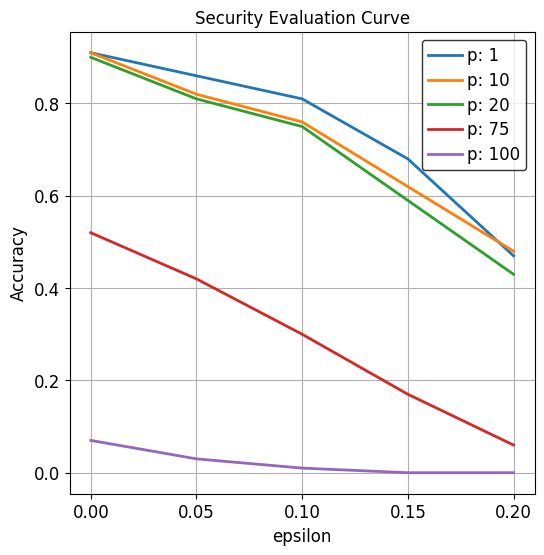

In [16]:
%matplotlib inline

fig = CFigure()
for (sec_eval_data, number_poisoning_points) in zip(sec_evals, n_poisoning_samples):
    fig.sp.plot_sec_eval(sec_eval_data, label=f"p: {number_poisoning_points}")
